## Probabilistic Model

- Network of potential contacts(Adjacency matrix)
- Undirected
- Connected components
- Probabilistic Model
    - $s_{i}(t)$ - probability at time t node i is susceptible
    - $x_{i}(t)$ - probability at time t node i is infected
    - $r_{i}(t)$ - probability at time t node i is recovered
    - $\beta$ - Infection rate, probability to get infected in a period $\delta_{t}$
    - $\gamma$ - Recovery rate, probability to get recovered in a unit time $\delta_{t}$


#### Infection - 传染概率

1. $\beta  x_{j}(t)\delta_{t}$ - Probability of a infected node j infect other node within unit time delta t
2. $1 - \beta  x_{j}(t)\delta_{t}$ - Probability of a infected node j not infect other node within unit time delta t
3. $\prod_{j\in{N(i)}}(1 - \beta  x_{j}(t)\delta_{t})$ - Probablity of all the neighbors of i not infect i
4. $1 - \prod_{j\in{N(i)}}(1 - \beta  x_{j}(t)\delta_{t})$ - Probablity of node i being infected by some of its neighbors N(i)
4. $P(inf) = s(i)(1 - \prod_{j\in{N(i)}}(1 - \beta  x_{j}(t)\delta_{t}))$ - Probablity of an uninfected node i being infected by its neighbors
5. $P(inf)\approx \beta s(i) \sum_{j\in{N(i)}} x_{j}(t)\delta_{t}$        
6. $P(inf)\approx \beta s(i) \sum_{j} A_{ij}x_{j}(t)\delta_{t}$


#### Recovery - 恢复概率
$P(rec) = \gamma x_{i}(t) \delta_{t}$

## Modelling SIS

- Every node at any timestep is in one state ${S,I}$
- Initialize c node with state $I$
- Each node stays infected for $1/\gamma$ time steps
- On each timestep node $I$ has a probability $\beta$ to infect its nearest neighbors $NN$
- After $1/\gamma$ time steps, $I$ node recoveryed

In [0]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.core.pylabtools import figsize

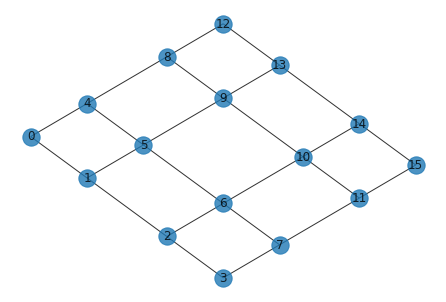

In [2]:
G = nx.grid_2d_graph(4,4)
rename_dict = {(x,y):x*4 + y for x,y in G.nodes()}
G = nx.relabel_nodes(G,rename_dict)
nx.draw_spectral(G,with_labels = True,alpha = .8)

在上一个时间段内，已感染人群有几率恢复，也可能在这个过程中继续感染别人      
上一个阶段的$I$在本阶段有可能恢复       
上一个阶段的$I$在本阶段有可能继续感染别人     
上一个阶段的$S$在本阶段有可能被感染      

### Simulate SIS

In [0]:
def simulate_SIS(G,params):

    time_steps = params.get('time_steps',11)
    max_rectime = params.get('max_rectime',3)
    init_inf_size = params.get('init_inf_size',3)
    beta = params.get('beta',0.1)
    infected = params.get('infected',[])


    # convert to numpy matrix
    A = nx.to_numpy_array(G)

    # recovery status save to a numpy array rec_time
    n_nodes = A.shape[0]
    rec_time = np.zeros((n_nodes,))

    # initialize infected nodes if not specified
    if len(infected) == 0:
        infected = np.random.choice(range(n_nodes),init_inf_size,replace = False)

    # initialize recovery time - the infected state lasts for max_rectime steps, so you need to add 1
    # not recovery at the max_rectime(th) step
    rec_time[infected] = max_rectime + 1

    # intialize states
    states = np.zeros((n_nodes,time_steps + 1))
    states[infected,0] = 1

    # start infection
    for t in range(1,time_steps + 1):

        # update recovery
        # if recovered, you not infect others
        rec_time = np.maximum(rec_time - 1, 0)
        states[rec_time > 0,t]  = 1
        states[rec_time == 0,t] = 0

        # update infection
        cur_inf = np.nonzero(states[:,t])[0]
        states[cur_inf,t] = 1

        for i in cur_inf:
            nei = np.nonzero(A[i,])[0]
            inf_nei = nei[np.random.random(size = len(nei)) < beta]
            states[inf_nei,t] = 1
            rec_time[inf_nei] = max_rectime + 1
    return states

### SIS on grid graph

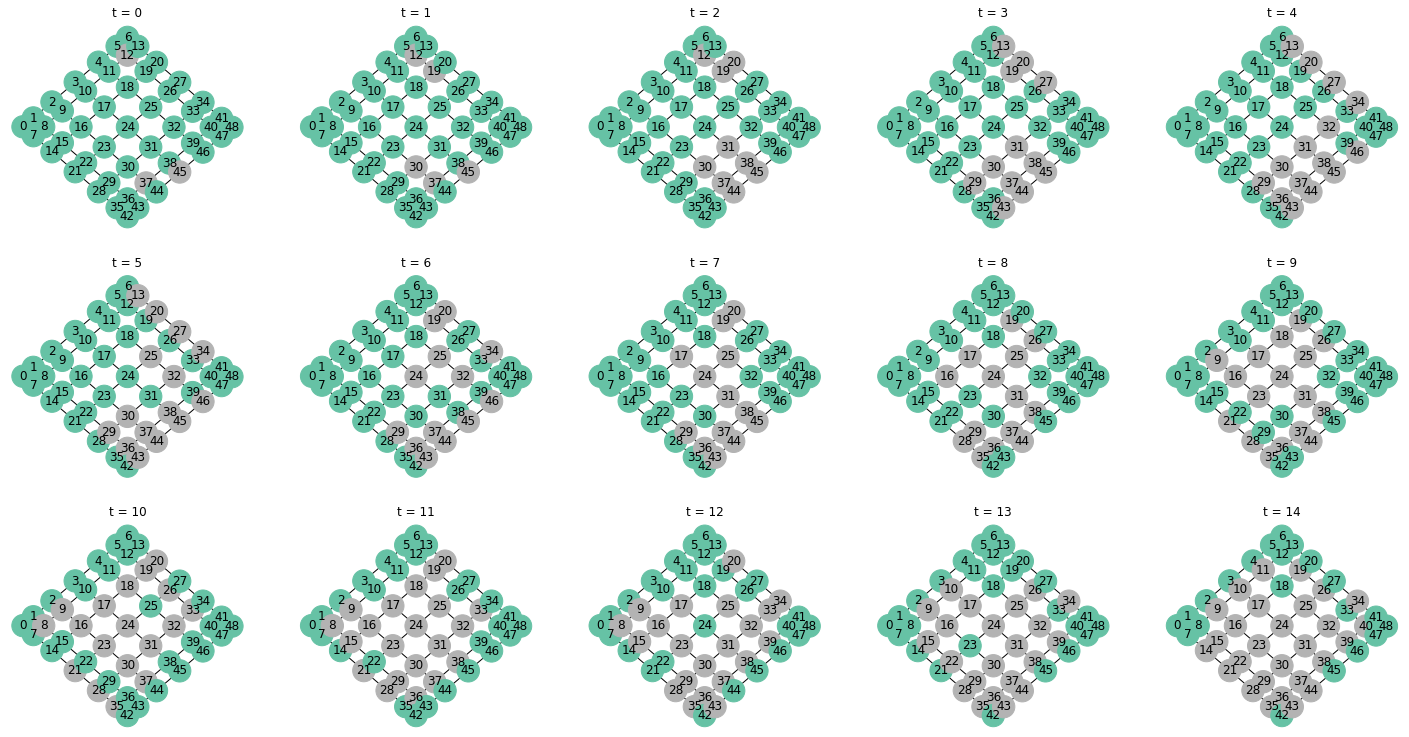

In [84]:
grid_size = 7
G = nx.grid_2d_graph(grid_size,grid_size)
rename_dict = {(x,y):x*grid_size + y for x,y in G.nodes()}
G = nx.relabel_nodes(G,rename_dict)

params = {
    'time_steps':15,
    'max_rectime':2,
    'init_inf_size':3,
    'beta':0.2,
    'infected':[]
}

states = simulate_SIS(G,params)


view_steps = 15
figsize(25,13)
for i in range(view_steps):
    plt.subplot(3,5,i+1)

    nx.draw_spectral(G,node_color = states[:,i],with_labels = True,node_size = 500,cmap = plt.get_cmap('Set2'))

    plt.title('t = {}'.format(i))
plt.show()

### SIS on a branching tree

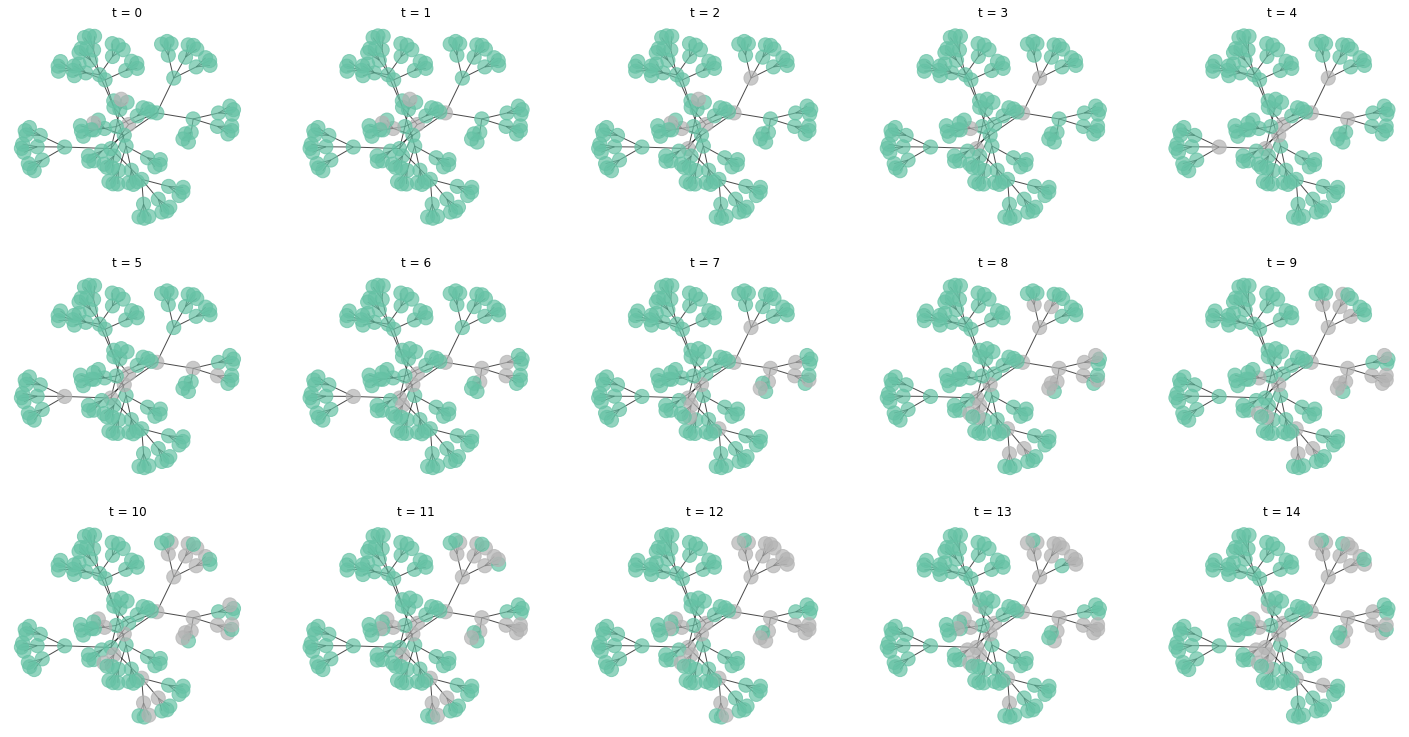

In [103]:
G = nx.balanced_tree(3,4)

pos = nx.spring_layout(G)

params = {
    'time_steps':15,
    'max_rectime':2,
    'init_inf_size':3,
    'beta':0.3,
    'infected':[]
}

states = simulate_SIS(G,params)


view_steps = 15
figsize(25,13)
for i in range(view_steps):

    plt.subplot(3,5,i+1)
    
    nx.draw(G,
            node_color = states[:,i],
            alpha = 0.7,
            node_size = 200,
            cmap = plt.get_cmap('Set2'),
            pos = pos)

    plt.title('t = {}'.format(i))
plt.show()

### Simulate SIR

In [0]:
def simulate_SIR(G,params):

    time_steps = params.get('time_steps',11)
    max_rectime = params.get('max_rectime',3)
    init_inf_size = params.get('init_inf_size',3)
    beta = params.get('beta',0.1)
    infected = params.get('infected',[])


    # convert to numpy matrix
    A = nx.to_numpy_array(G)

    # recovery status save to a numpy array rec_time
    n_nodes = A.shape[0]
    rec_time = np.zeros((n_nodes,))

    # initialize infected nodes if not specified
    if len(infected) == 0:
        infected = np.random.choice(range(n_nodes),init_inf_size,replace = False)

    # initialize recovery time - the infected state lasts for max_rectime steps, so you need to add 1
    # not recovery at the max_rectime(th) step
    rec_time[infected] = max_rectime + 1

    # intialize states
    states = np.zeros((n_nodes,time_steps + 1))
    states[infected,0] = 1

    ever_infected = infected.tolist()
    # start infection
    for t in range(1,time_steps + 1):

        # update recovery
        # if recovered, you not infect others
        rec_time = np.maximum(rec_time - 1, 0)
        states[rec_time > 0,t]  = 1
        states[rec_time == 0,t] = 0

        # update infection
        cur_inf = np.nonzero(states[:,t])[0]
        states[cur_inf,t] = 1

        for i in cur_inf:
            nei = np.nonzero(A[i,])[0]
            nei = np.array([n for n in nei if n not in ever_infected])
            if len(nei)>0:
                inf_nei = nei[np.random.random(size = len(nei)) < beta]
                states[inf_nei,t] = 1
                rec_time[inf_nei] = max_rectime + 1
                ever_infected += inf_nei.tolist()
    return states

### SIR on grid graph

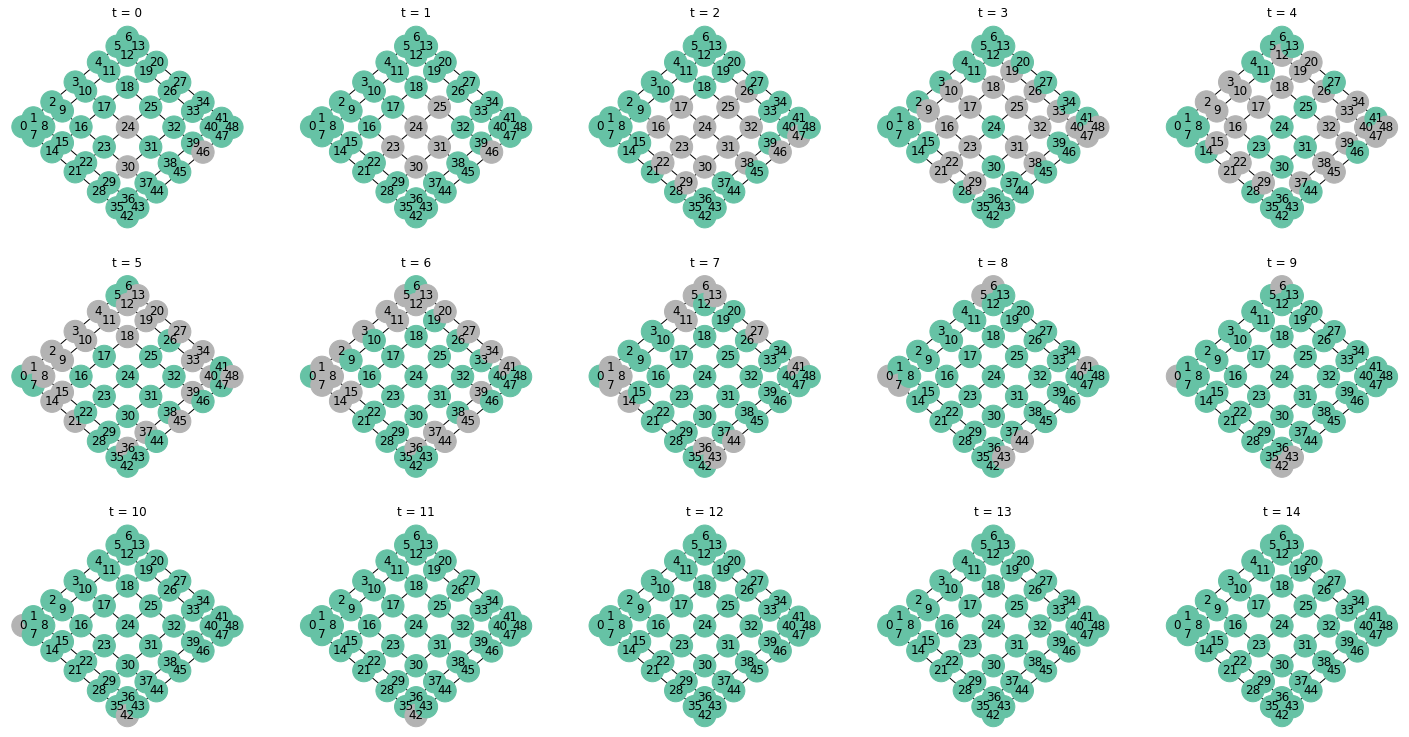

In [121]:
grid_size = 7
G = nx.grid_2d_graph(grid_size,grid_size)
rename_dict = {(x,y):x*grid_size + y for x,y in G.nodes()}
G = nx.relabel_nodes(G,rename_dict)

params = {
    'time_steps':15,
    'max_rectime':2,
    'init_inf_size':3,
    'beta':0.4,
    'infected':[]
}

states = simulate_SIR(G,params)


view_steps = 15
figsize(25,13)
for i in range(view_steps):
    plt.subplot(3,5,i+1)

    nx.draw_spectral(G,node_color = states[:,i],with_labels = True,node_size = 500,cmap = plt.get_cmap('Set2'))

    plt.title('t = {}'.format(i))
plt.show()

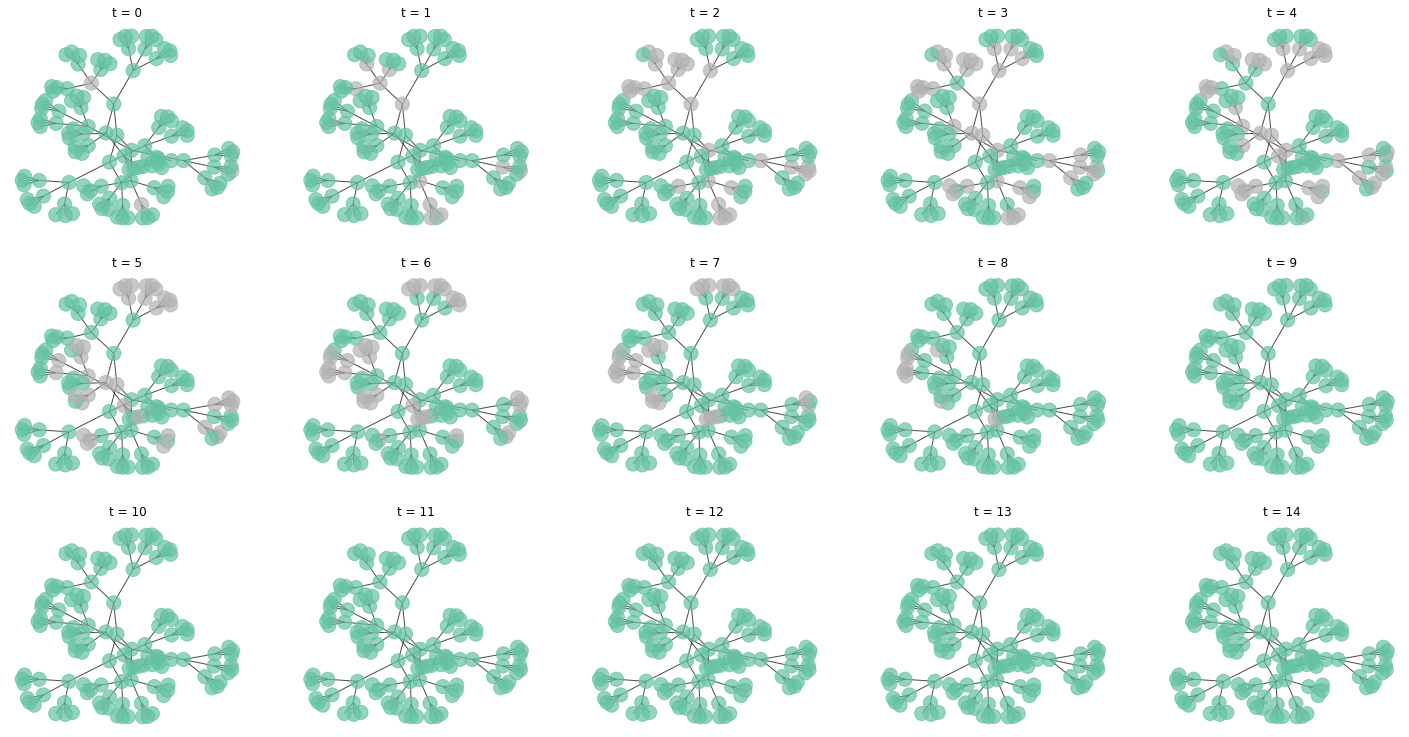

In [123]:
G = nx.balanced_tree(3,4)

pos = nx.spring_layout(G)

params = {
    'time_steps':15,
    'max_rectime':2,
    'init_inf_size':3,
    'beta':0.7,
    'infected':[]
}

states = simulate_SIR(G,params)


view_steps = 15
figsize(25,13)
for i in range(view_steps):

    plt.subplot(3,5,i+1)
    
    nx.draw(G,
            node_color = states[:,i],
            alpha = 0.7,
            node_size = 200,
            cmap = plt.get_cmap('Set2'),
            pos = pos)

    plt.title('t = {}'.format(i))
plt.show()